## Imports and Cleaning

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
!cd ~/Documents/Data_Projects/COVID/COVID-19

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

from datetime import timedelta
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi']= 600
sns.set()

import scipy.stats as stats
from scipy.optimize import curve_fit

import statsmodels.api as sm
from sklearn.metrics import r2_score

from data_clean import *
from model_helper import *
%load_ext autoreload
%autoreload 2

In [3]:
# Read in live data (countries from Johns Hopkins, states + count)
countries = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
local = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

testing = pd.read_json('https://covidtracking.com/api/v1/states/daily.json')

In [4]:
df_country = clean_data_hopkins(countries, country='all')
df_state = clean_data_nyt(states, level='state')
df_local = clean_data_nyt(local, level='local')

df_testing = clean_data_trackingproject(testing)

/anaconda3/envs/covid/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/anaconda3/envs/covid/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df_testing.loc[df_testing.State.isin(['NY'])].tail(3)

,State,Date,Positive,Negative,Pending,HospitalizedCurrently,HospitalizedCumulative,InIcuCurrently,InIcuCumulative,OnVentilatorCurrently,OnVentilatorCumulative,Recovered,Death,Hospitalized,Total,TotalTestResults,PosNeg,DeathIncrease,HospitalizedIncrease,NegativeIncrease,PositiveIncrease,TotalTestResultsIncrease
1350,NY,2020-04-08,149316.0,215837.0,NaN,18079.0,32669.0,4593.0,NaN,NaN,NaN,14590.0,6268.0,32669.0,365153,365153,365153,779.0,586.0,14642.0,10453.0,25095.0
1351,NY,2020-04-09,159937.0,231612.0,NaN,18279.0,32869.0,4925.0,NaN,NaN,NaN,14590.0,7067.0,32869.0,391549,391549,391549,799.0,200.0,15775.0,10621.0,26396.0
1352,NY,2020-04-10,170512.0,247373.0,NaN,18569.0,33159.0,4908.0,NaN,NaN,NaN,14590.0,7844.0,33159.0,417885,417885,417885,777.0,290.0,15761.0,10575.0,26336.0


In [6]:
df_state.loc[df_state.State == 'New York'].tail(3)

,State,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
1310,New York,2020-04-07,140081,2020-03-03,36,9378.0,3.583519,11.849976,9.146122
1311,New York,2020-04-08,149401,2020-03-03,37,9320.0,3.610918,11.914389,9.139918
1312,New York,2020-04-09,159937,2020-03-03,38,10536.0,3.637586,11.982535,9.262553


In [7]:
US = df_country.loc[df_country.Country=='US']
US.tail(3)

,Country,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
14416,US,2020-04-08,429052,2020-01-24,76,32829.0,4.330733,12.969333,10.399068
14601,US,2020-04-09,461437,2020-01-24,77,32385.0,4.343805,13.042101,10.385451
14786,US,2020-04-10,496535,2020-01-24,78,35098.0,4.356709,13.115409,10.465899


## Regression of Actual Cases

In [8]:
US_trimmed = US[US.Date > pd.to_datetime('2020-03-01').date()]
US_trimmed.head(3)

,Country,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
7571,US,2020-03-02,98,2020-01-24,39,24.0,3.663562,4.584967,3.178054
7756,US,2020-03-03,118,2020-01-24,40,20.0,3.688879,4.770685,2.995732
7941,US,2020-03-04,149,2020-01-24,41,31.0,3.713572,5.003946,3.433987


### Fitting Exponential

In [9]:
x = US_trimmed.DaysElapsed.values
y = US_trimmed.Confirmed.values

In [10]:
# Regressing on last 14 days
params, covar = curve_fit(lambda t,a,b: a*np.exp(b*t),  x[-14:],  y[-14:], p0=(2,.1))
y_hat_scipy = params[0]*np.exp(params[1]*x)
r2_scipy = r2_score(y, y_hat_scipy)

In [11]:
# Unweighted Regression (Higher magnitudes of Y implicitly weighted higher)
params = np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
y_hat_numpy = np.exp(params[1]) * np.exp(params[0] * x)
r2_numpy = r2_score(y, y_hat_numpy)

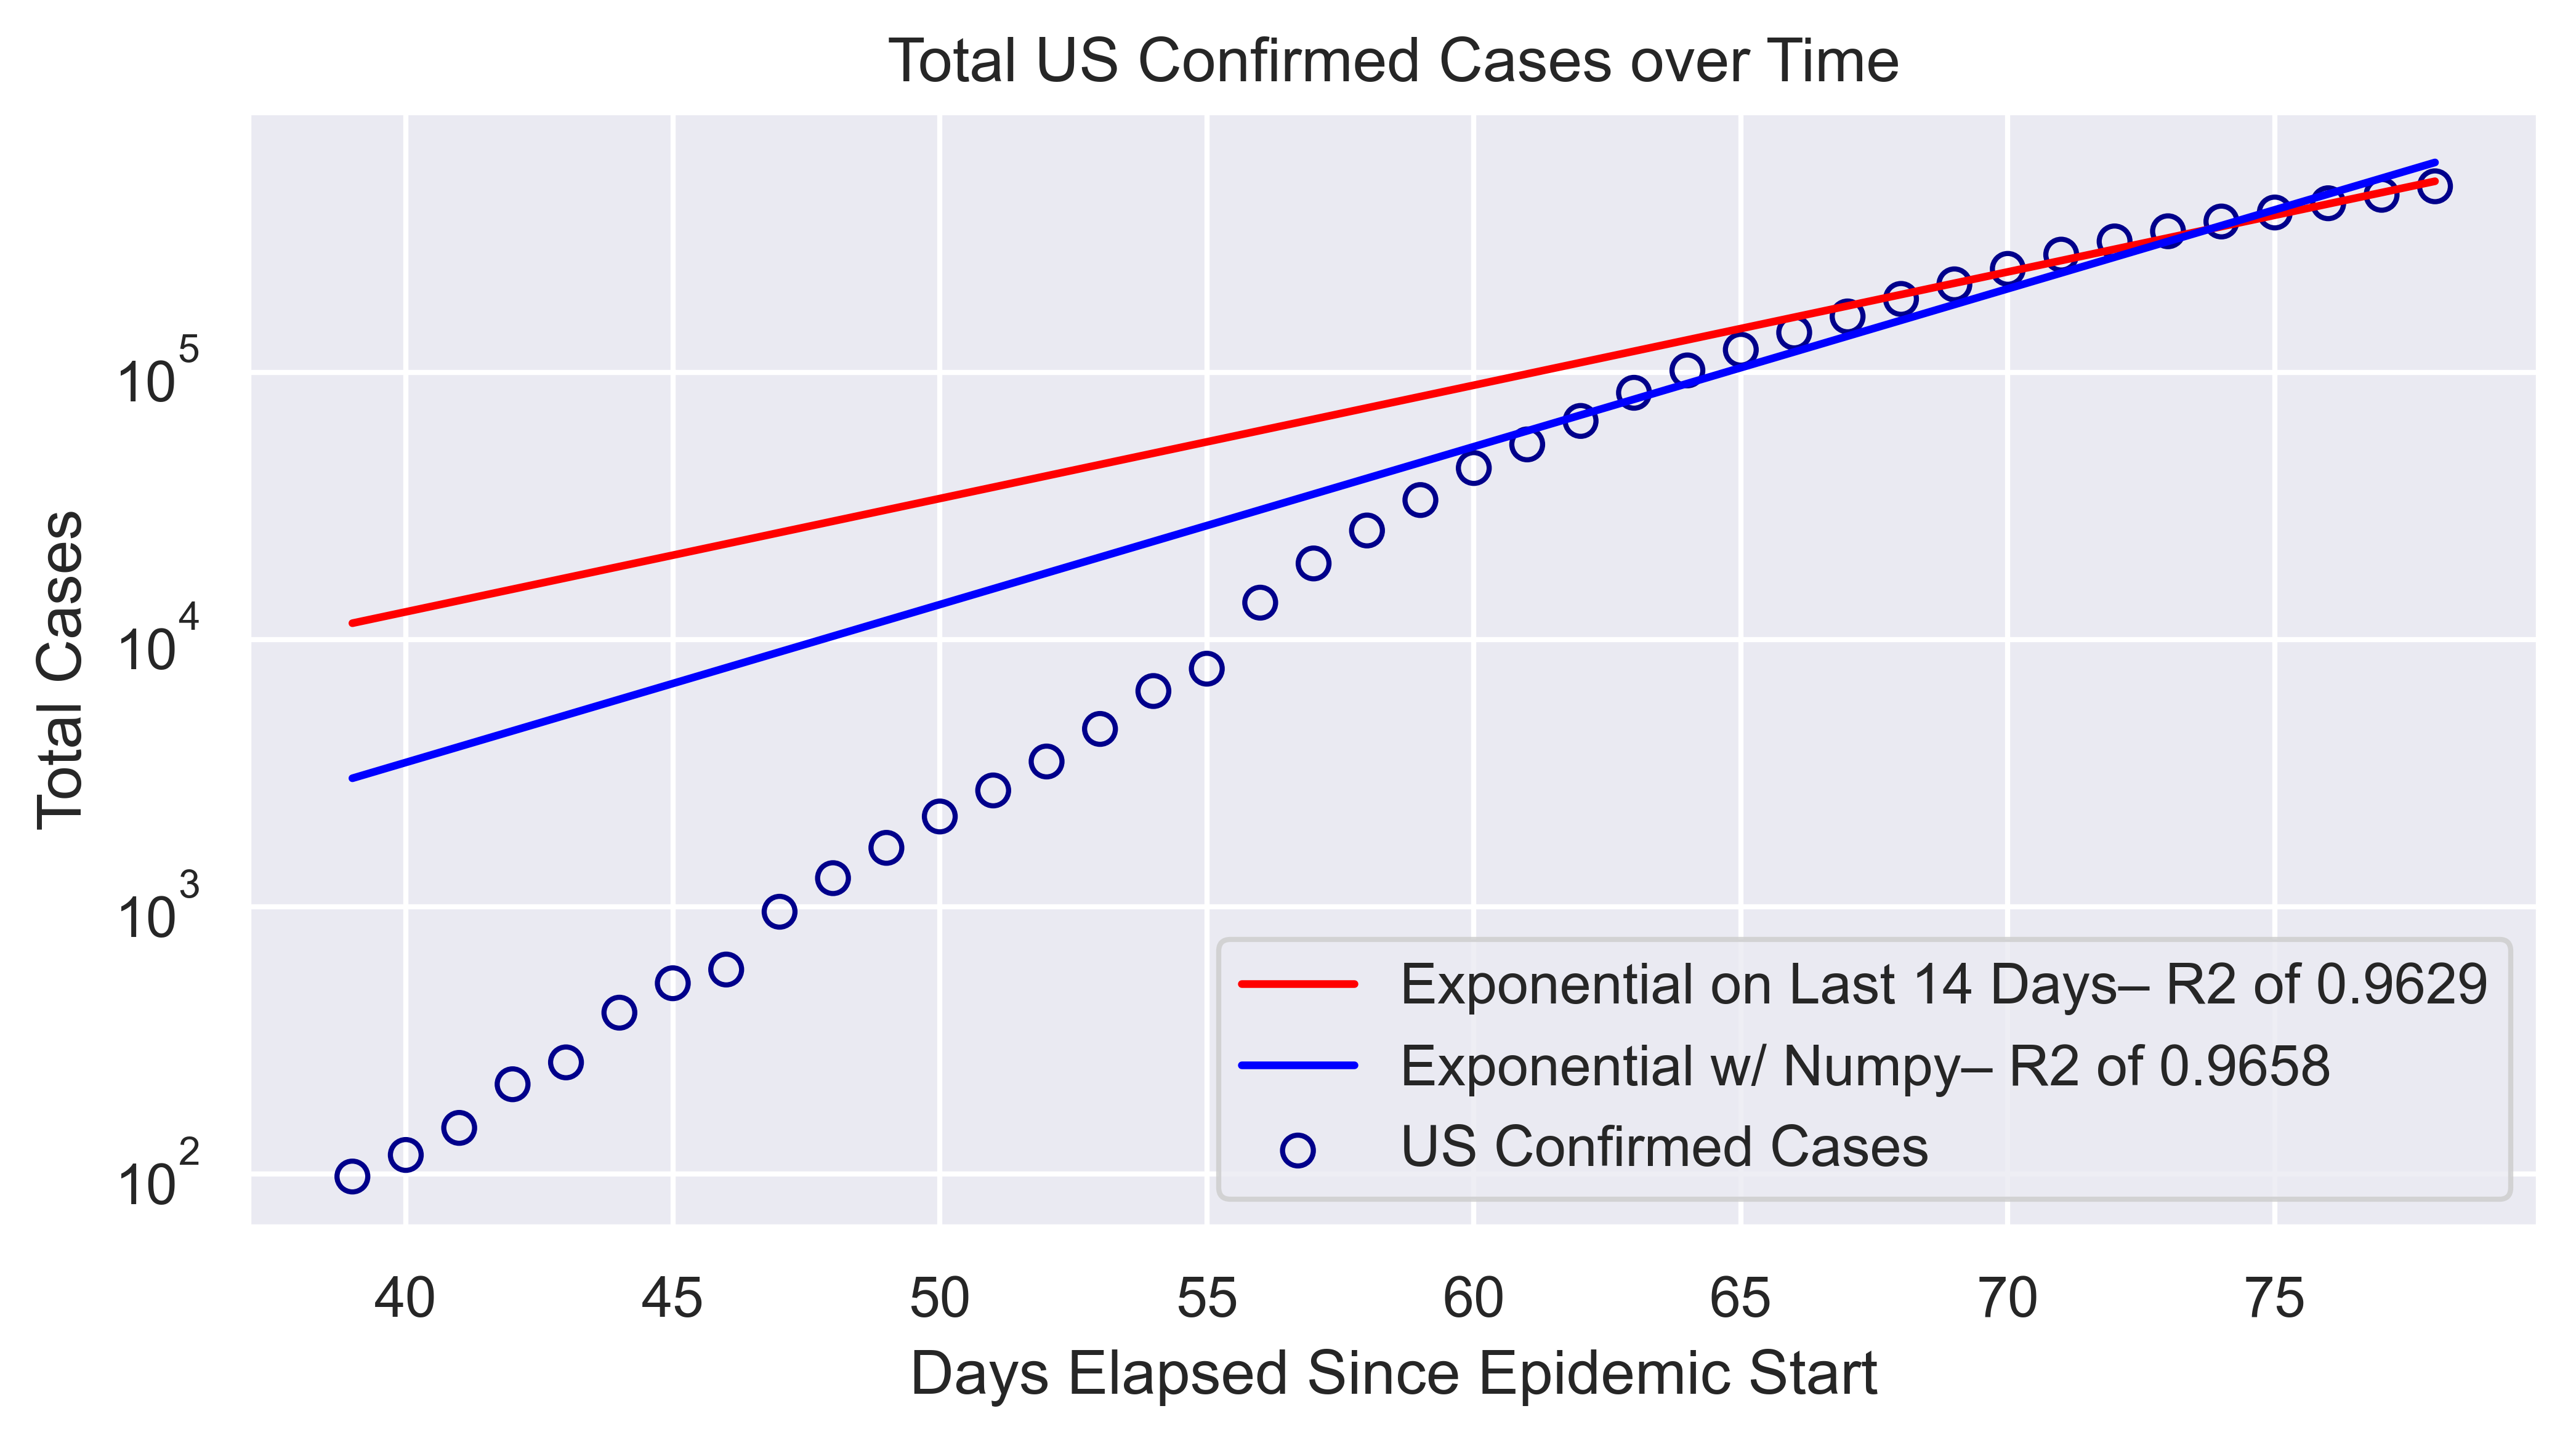

In [12]:
## Make this into log v unlogged side by side comparison

plt.figure(figsize=(8,4))
plt.scatter(x, y, facecolors = 'none', edgecolor = 'darkblue', label = 'US Confirmed Cases')
plt.plot(x, y_hat_scipy, color = 'red', label = 'Exponential on Last 14 Days– R2 of %2.4f'%r2_scipy)
plt.plot(x, y_hat_numpy, color = 'blue', label = 'Exponential w/ Numpy– R2 of %2.4f'%r2_numpy)

plt.yscale('log') 

plt.legend()
plt.ylabel('Total Cases')
plt.xlabel('Days Elapsed Since Epidemic Start')
plt.title('Total US Confirmed Cases over Time')
plt.show()

### Using weighted local regression (LOWESS)

In [13]:
x = US_trimmed.DaysElapsed.values
y = US_trimmed.Confirmed.values

In [14]:
y_lowess = regress_lowess(x, y)

d = 3
x_range, y_hat = predict(x, y_lowess, days=d, extend=False)

preds = pd.DataFrame(list(zip(x_range, np.around(y_hat,0))), columns =['DaysElapsed', 'Confirmed Predictions']) 
preds

R2 for LOWESS: 0.99995


,DaysElapsed,Confirmed Predictions
0,79,527778.0
1,80,560448.0
2,81,593119.0


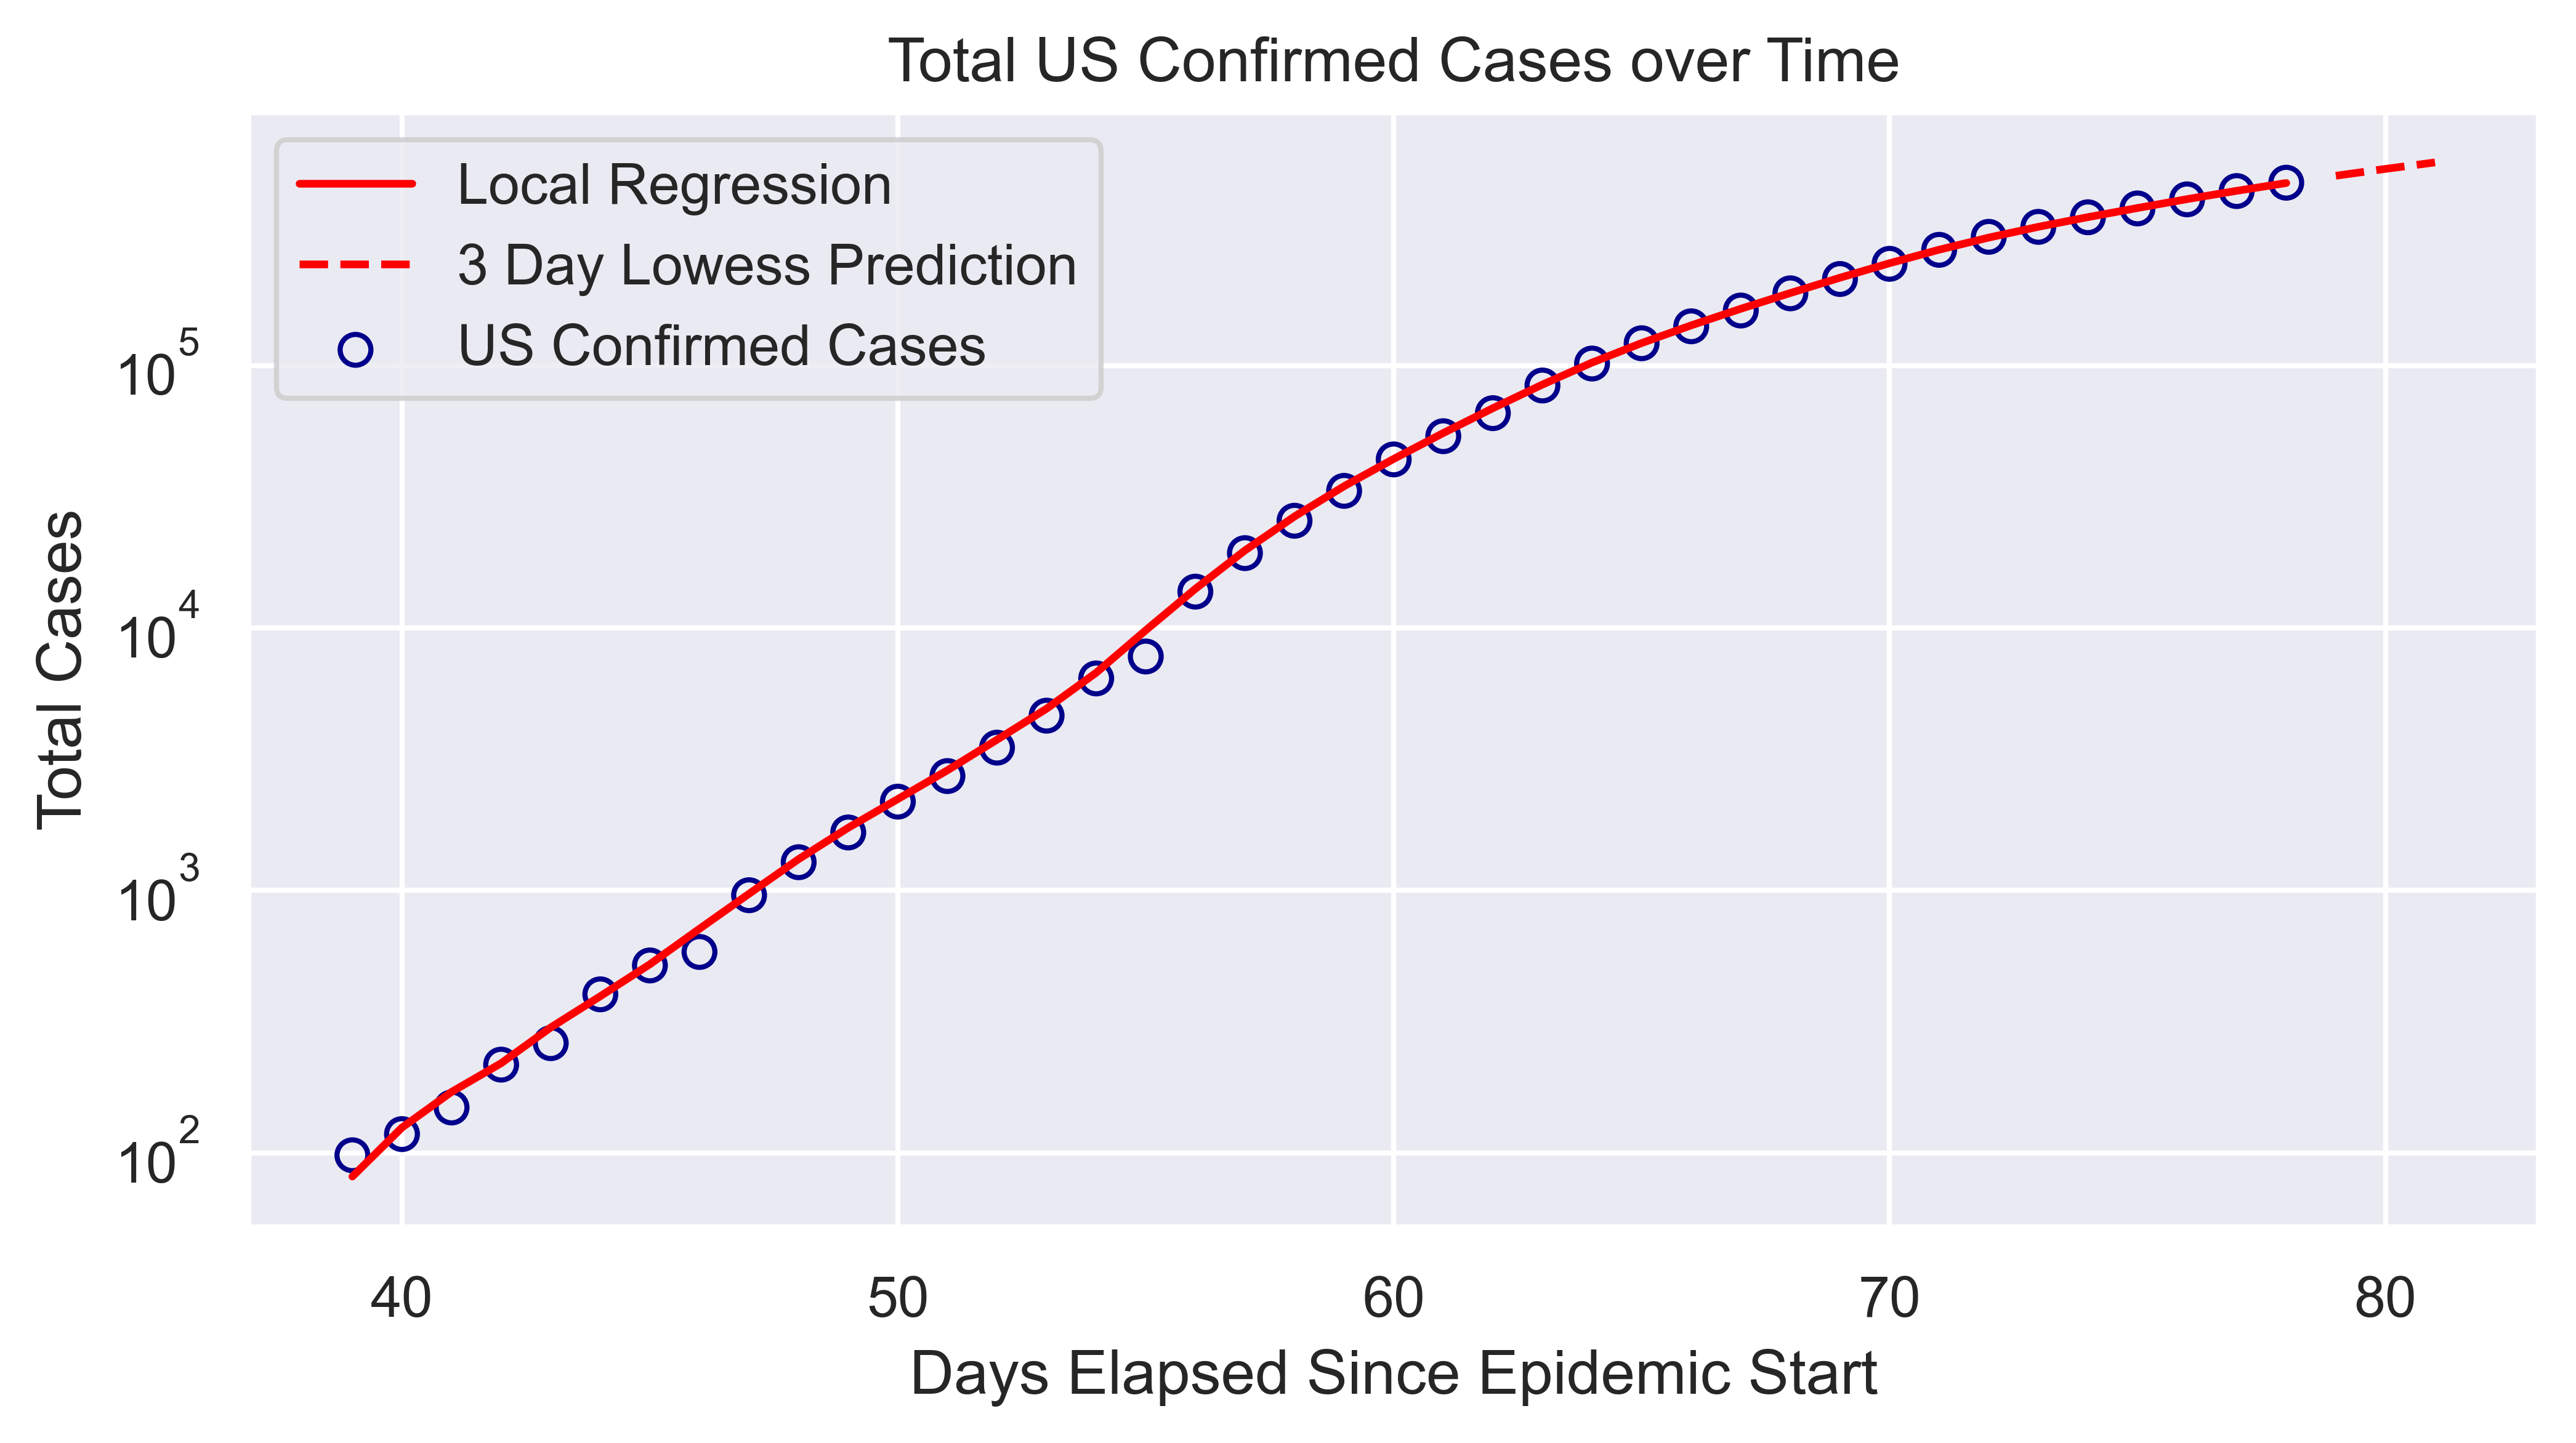

In [15]:
plt.figure(figsize=(8,4))

plt.scatter(x, y, facecolors = 'none', edgecolor = 'darkblue', label = 'US Confirmed Cases')
plt.plot(x, y_lowess, color = 'red', label = 'Local Regression')

plt.plot(x_range, y_hat, '--', color = 'red', label = '{} Day Lowess Prediction'.format(d))

plt.yscale('log')

plt.legend()
plt.ylabel('Total Cases')
plt.xlabel('Days Elapsed Since Epidemic Start')
plt.title('Total US Confirmed Cases over Time')
plt.show()

### Using compounded growth

Using the logarithmic approximation

In [16]:
x = US_trimmed.DaysElapsed.values[1:]
y = US_trimmed.Confirmed_Log.diff(periods=1).values[1:] 

In [17]:
# Only consider the last 2 weeks to regress on
params = np.polyfit(x[-14:],y[-14:],deg=1)
y_hat = x*params[0]+params[1]


y_t_1 = 366667
x_t = 76
y_t = y_t_1*np.exp(params[0]*x_t+params[1])
r2_score(y, y_hat)
# Create recursive prediction method

0.38328056518839815

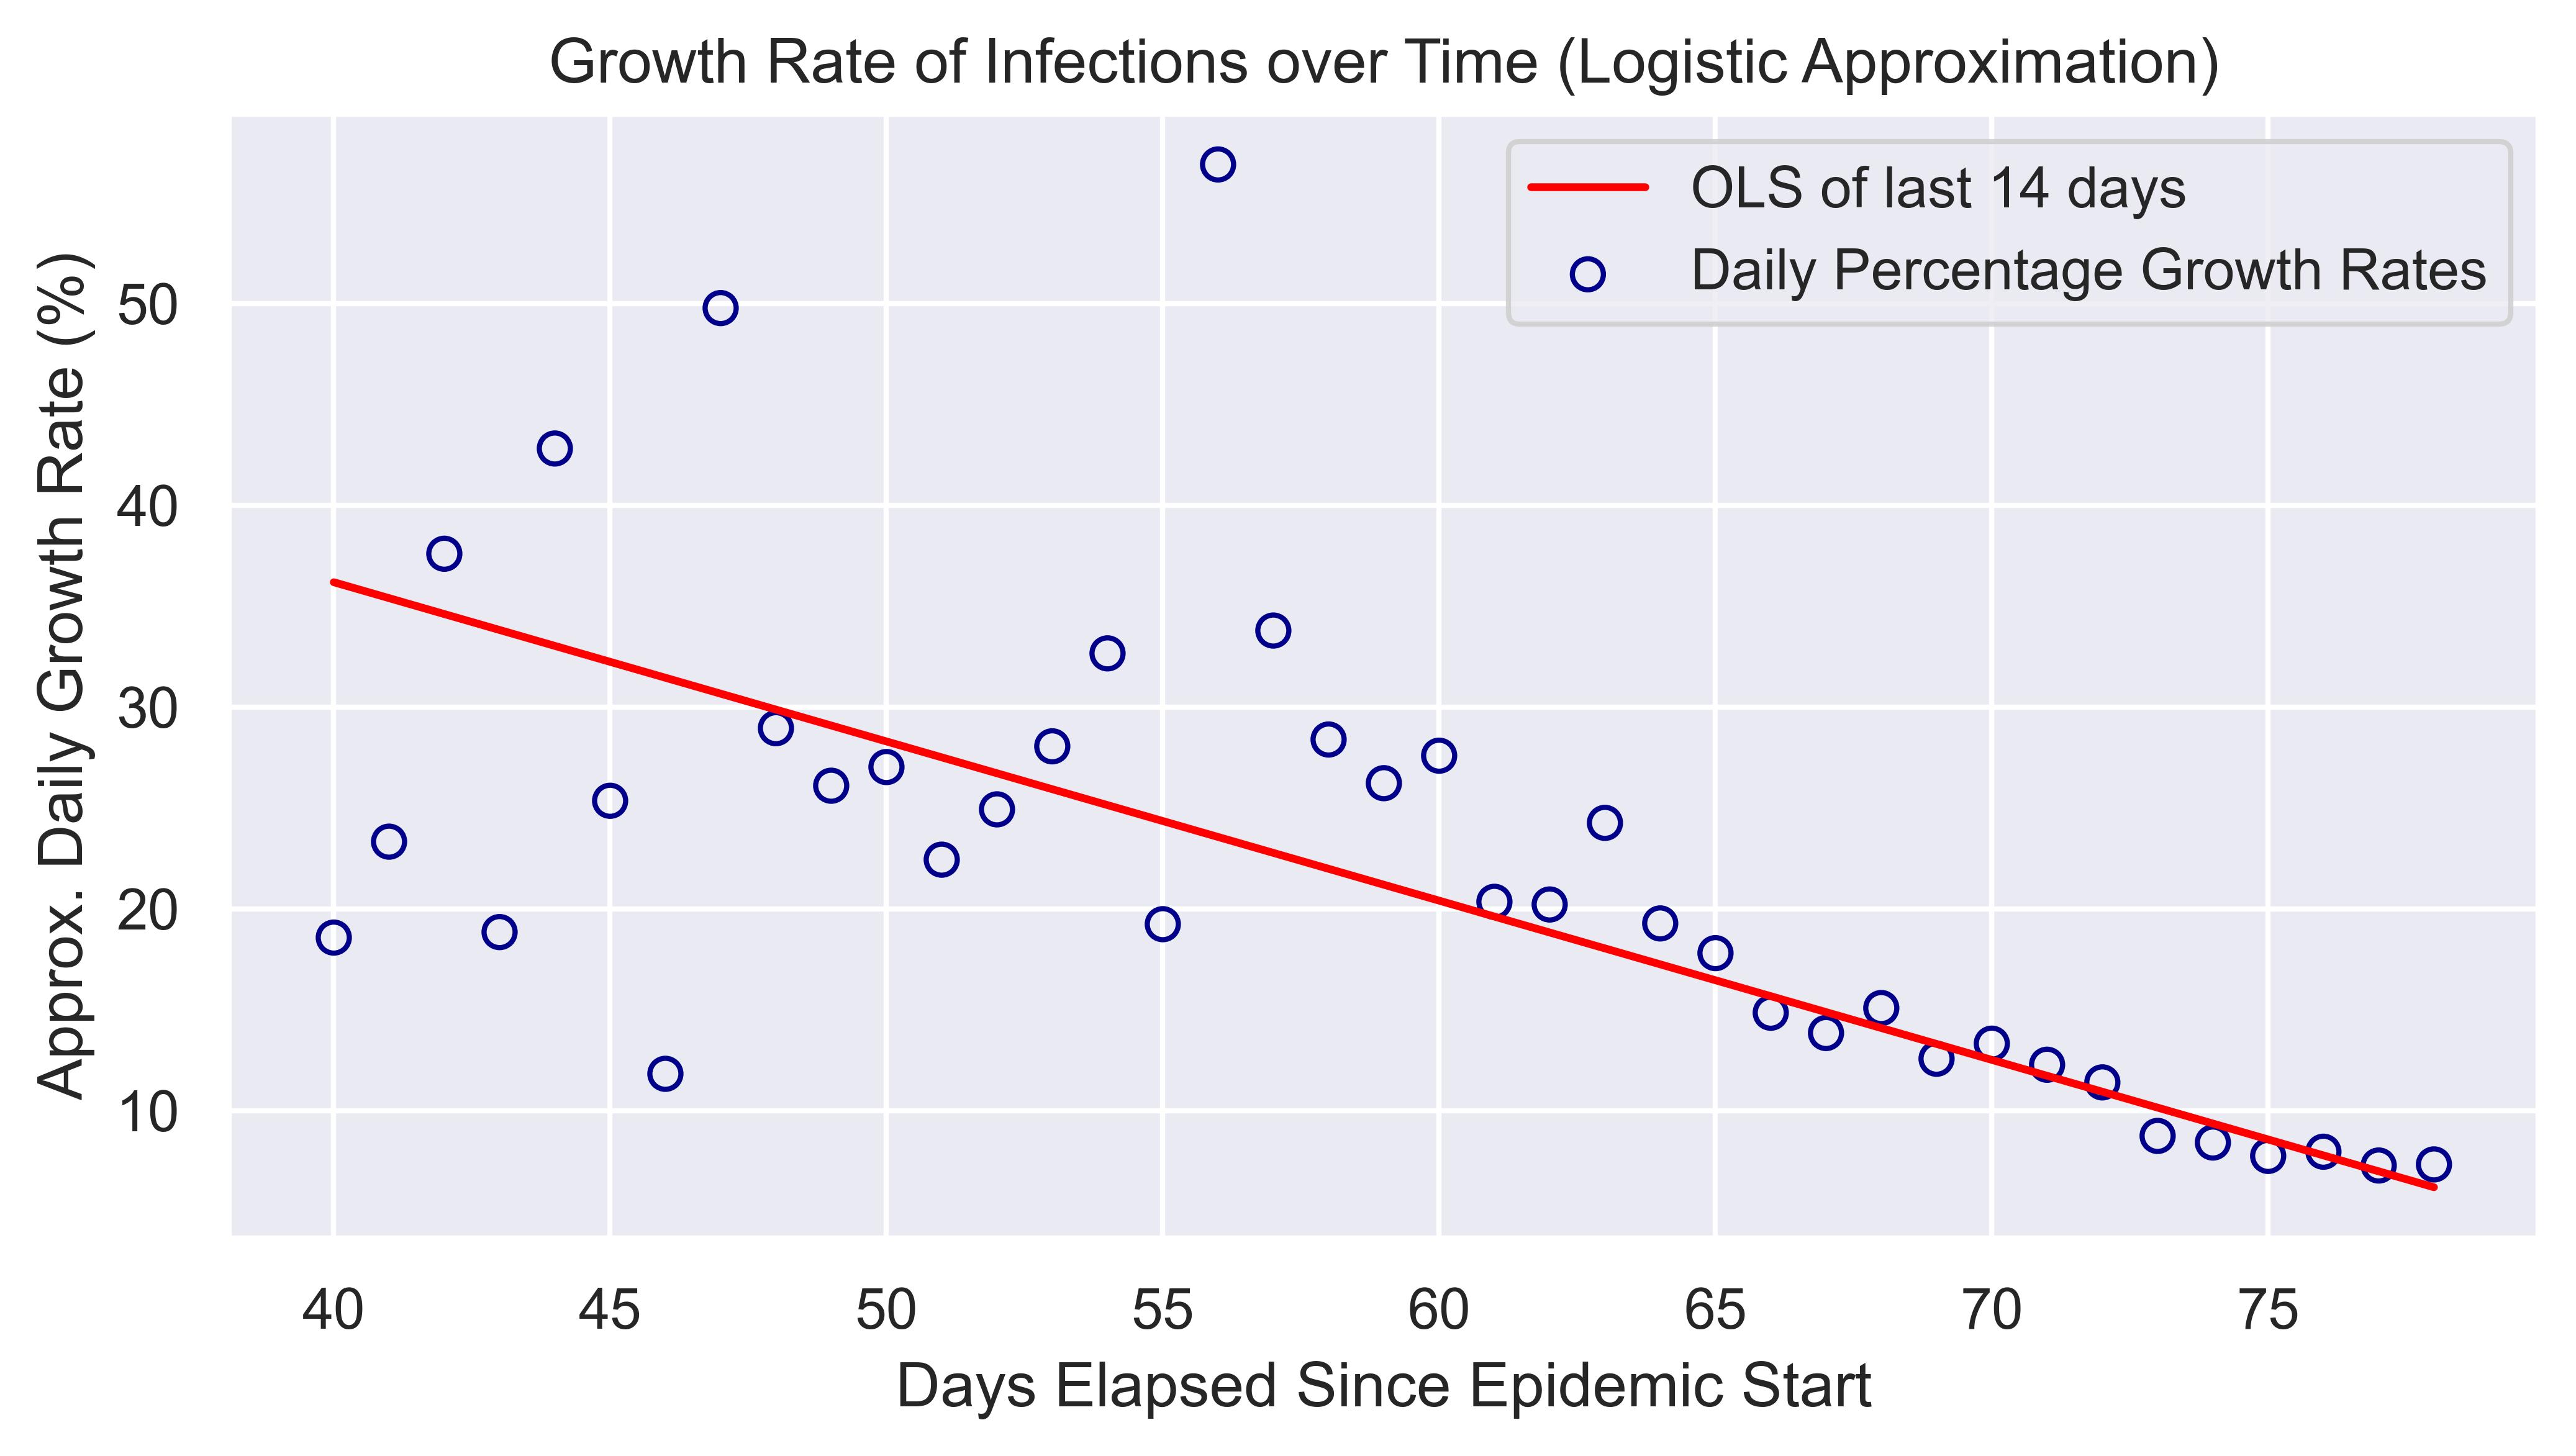

In [18]:
plt.figure(figsize=(8,4))
plt.scatter(x, y*100, facecolors = 'none', edgecolor = 'darkblue', label = 'Daily Percentage Growth Rates')
plt.plot(x, y_hat*100, color = 'red', label = 'OLS of last 14 days')
# plt.plot(x, exp[1], color = 'orange', label = 'exp')a


# ax.set_yticklabels(['{:,.2%}'.format(y) for y in ax.get_yticks()])

plt.legend()
plt.ylabel('Approx. Daily Growth Rate (%)')
plt.xlabel('Days Elapsed Since Epidemic Start')
plt.title('Growth Rate of Infections over Time (Logistic Approximation)')
plt.show()

Using actual daily growth rate in confirmed cases

In [19]:
x = US_trimmed.DaysElapsed.values[1:]
y = (US_trimmed.Confirmed/US_trimmed.Confirmed.shift(1)).values[1:]

In [20]:
# Only consider the last 2 weeks to regress on
params = np.polyfit(x[-14:],y[-14:],deg=1)
# params = np.polyfit(x,y,deg=1,w=x**2)
y_hat = x*params[0]+params[1]

# y_t_1 = 366667
# x_t = 76
# y_t = y_t_1*np.exp(params[0]*x_t+params[1])
r2_score(y, y_hat)
# # Create recursive prediction method

0.33733013053844074

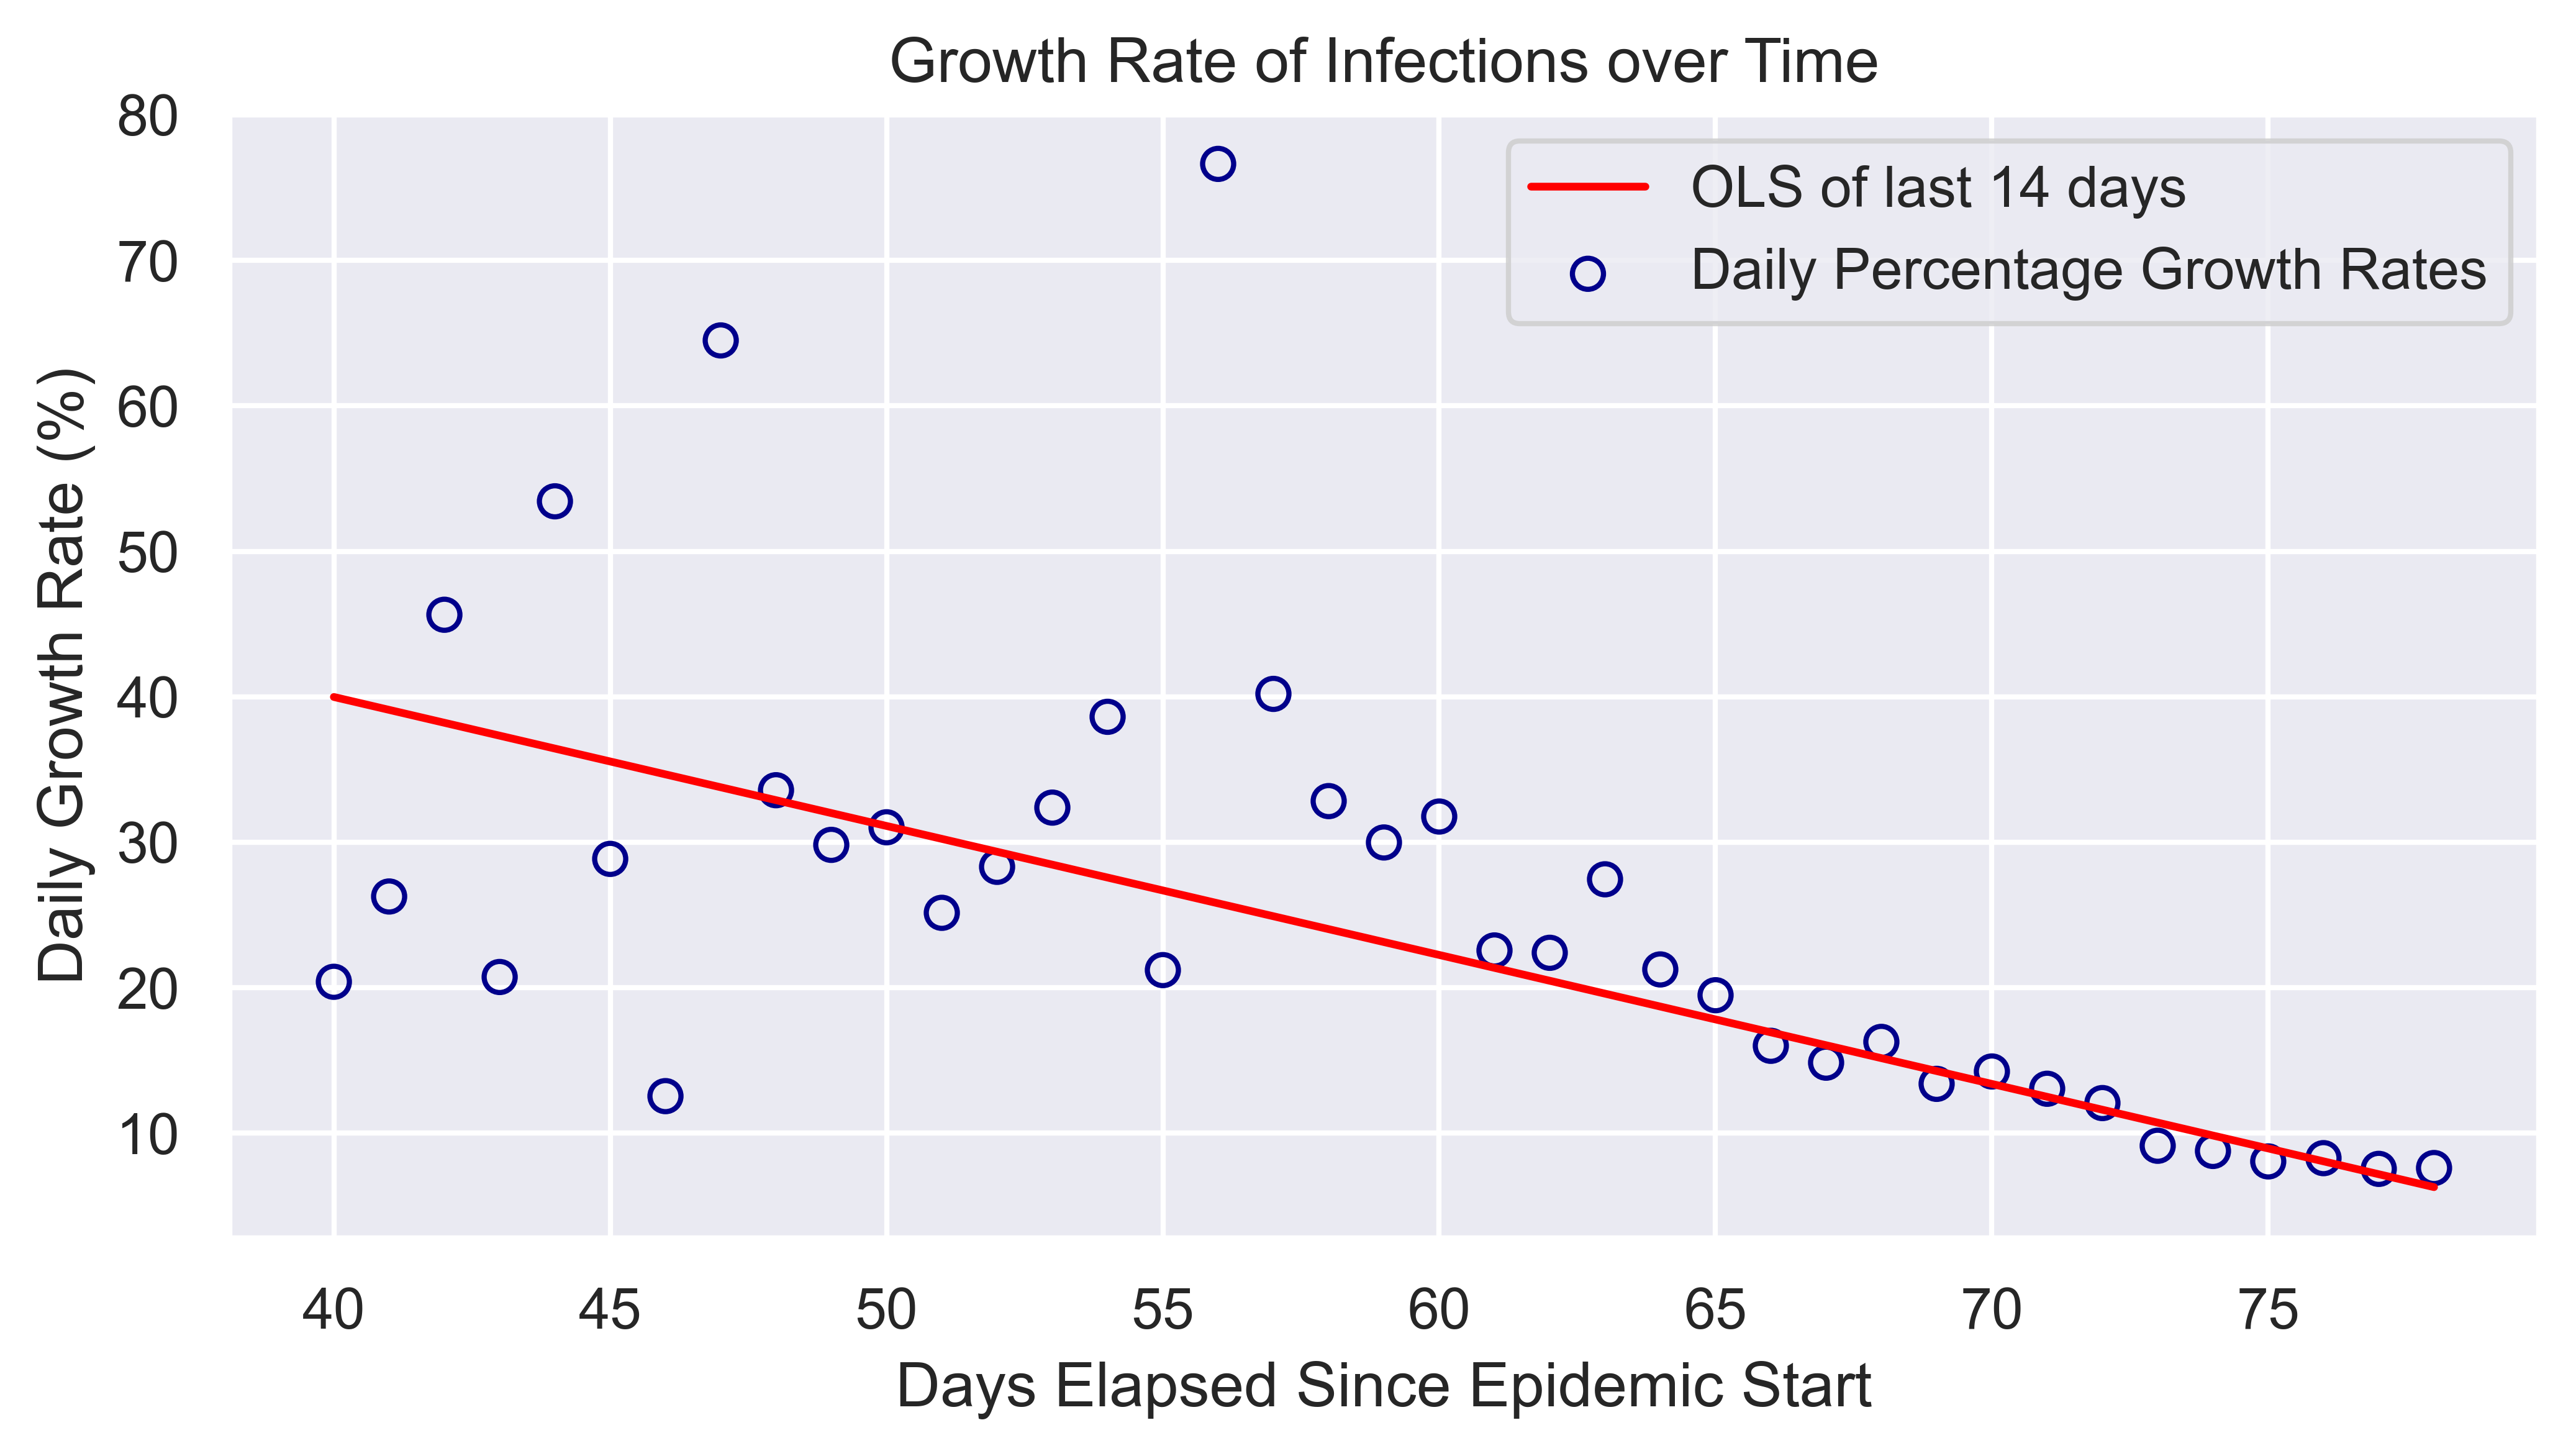

In [21]:
plt.figure(figsize=(8,4))
plt.scatter(x, y*100-100, facecolors = 'none', edgecolor = 'darkblue', label = 'Daily Percentage Growth Rates')
plt.plot(x, y_hat*100-100, color = 'red', label = 'OLS of last 14 days')
# plt.plot(x, exp[1], color = 'orange', label = 'exp')a


# ax.set_yticklabels(['{:,.2%}'.format(y) for y in ax.get_yticks()])

plt.legend()
plt.ylabel('Daily Growth Rate (%)')
plt.xlabel('Days Elapsed Since Epidemic Start')
plt.title('Growth Rate of Infections over Time')
plt.show()

### Regressing Logistic

Adapted from https://www.kaggle.com/lucaalbrizzo/robusteness-fits-and-mortality-rates-for-covid-19

In [22]:
from lmfit.models import ExponentialModel
model_exp = ExponentialModel()
params_exp = model_exp.guess(US_trimmed.Confirmed, x=US_trimmed.DaysElapsed)
result_exp = model_exp.fit(US_trimmed.Confirmed, params_exp, x=US_trimmed.DaysElapsed)

# result_exp

In [23]:
from lmfit.models import StepModel

model_log = StepModel(form='logistic')
params_log = model_log.guess(US_trimmed.Confirmed, x=US_trimmed.DaysElapsed)
result_log = model_log.fit(US_trimmed.Confirmed, params_log, x=US_trimmed.DaysElapsed)

result_log

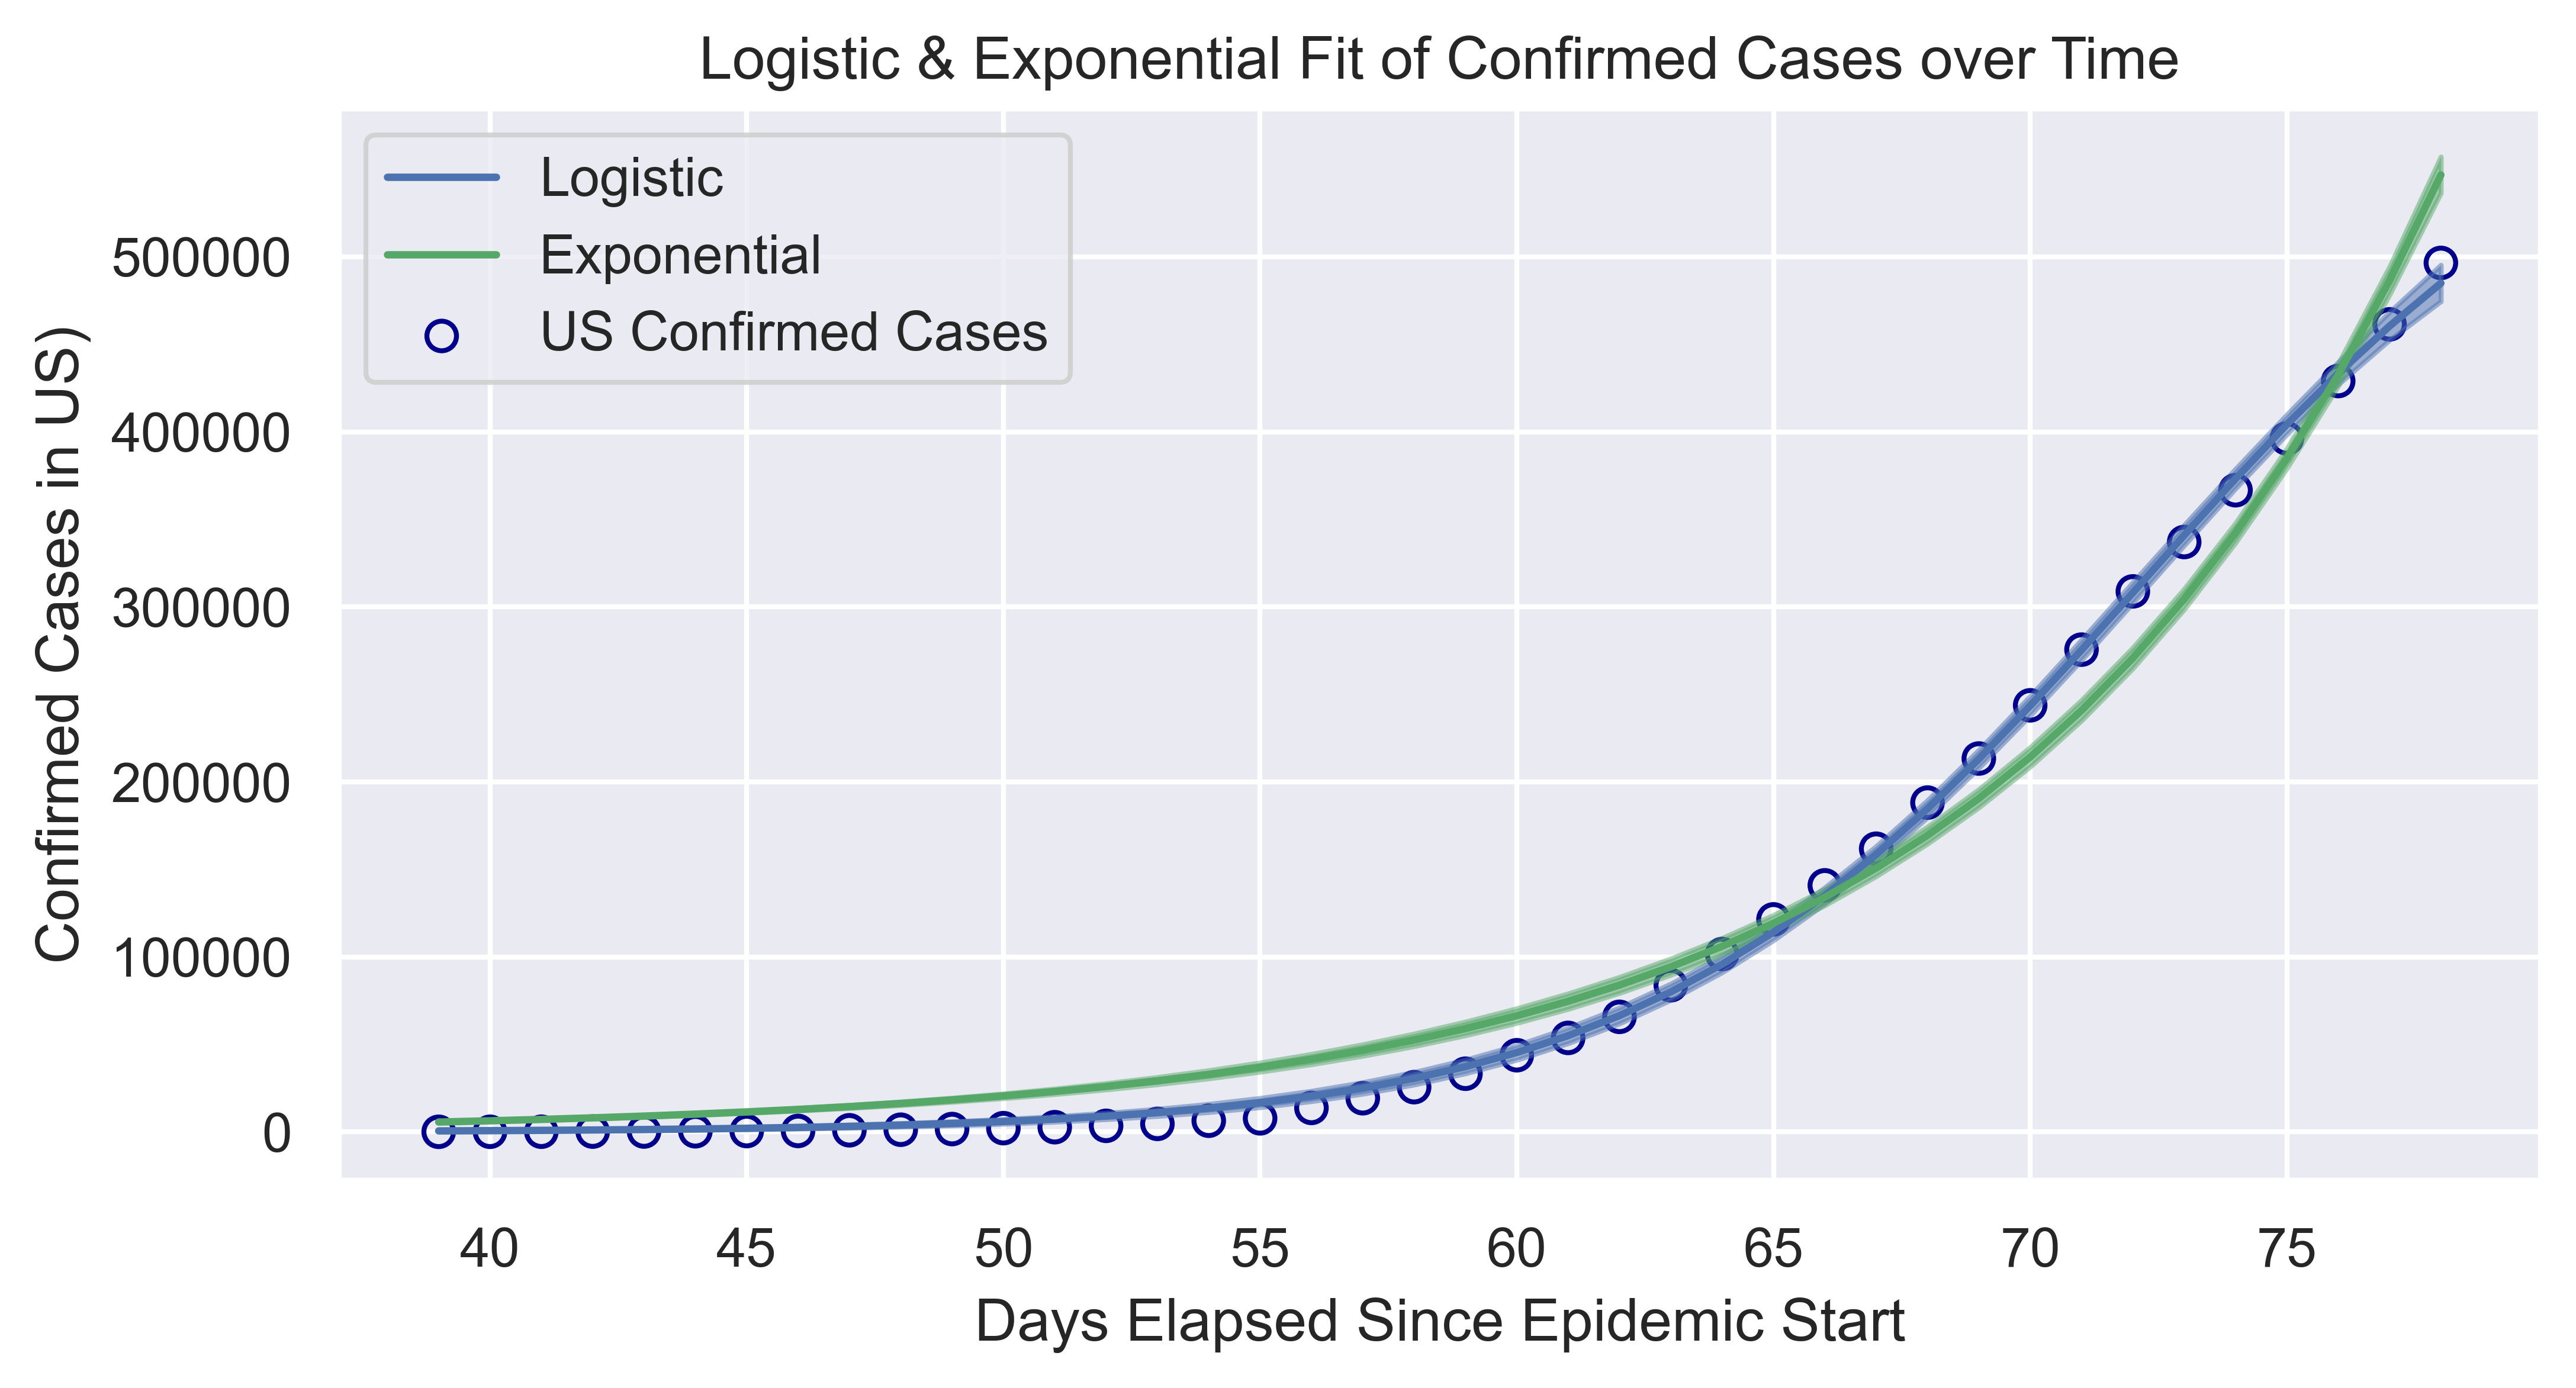

In [24]:
plt.figure(figsize=(8,4))

plt.scatter(US_trimmed.DaysElapsed, US_trimmed.Confirmed, 
            facecolors = 'none', edgecolor = 'darkblue', label = 'US Confirmed Cases')

plt.plot(US_trimmed.DaysElapsed, result_log.best_fit, color='b',
         label="Logistic")
plt.plot(US_trimmed.DaysElapsed, result_exp.best_fit, color='g',
         label="Exponential")

dely_log = result_log.eval_uncertainty(x=US_trimmed.DaysElapsed,sigma=3)
plt.fill_between(US_trimmed.DaysElapsed, 
                 result_log.best_fit-dely_log,
                 result_log.best_fit+dely_log, 
                 color='b',
                 alpha=0.5)

dely_exp = result_log.eval_uncertainty(x=US_trimmed.DaysElapsed,sigma=3)
plt.fill_between(US_trimmed.DaysElapsed, 
                 result_exp.best_fit-dely_exp,
                 result_exp.best_fit+dely_exp, 
                 color='g',
                 alpha=0.5)

# plt.yscale('log')

plt.legend()
plt.ylabel('Confirmed Cases in US)')
plt.xlabel('Days Elapsed Since Epidemic Start')
plt.title('Logistic & Exponential Fit of Confirmed Cases over Time')
plt.show()

## Modelling using SIR

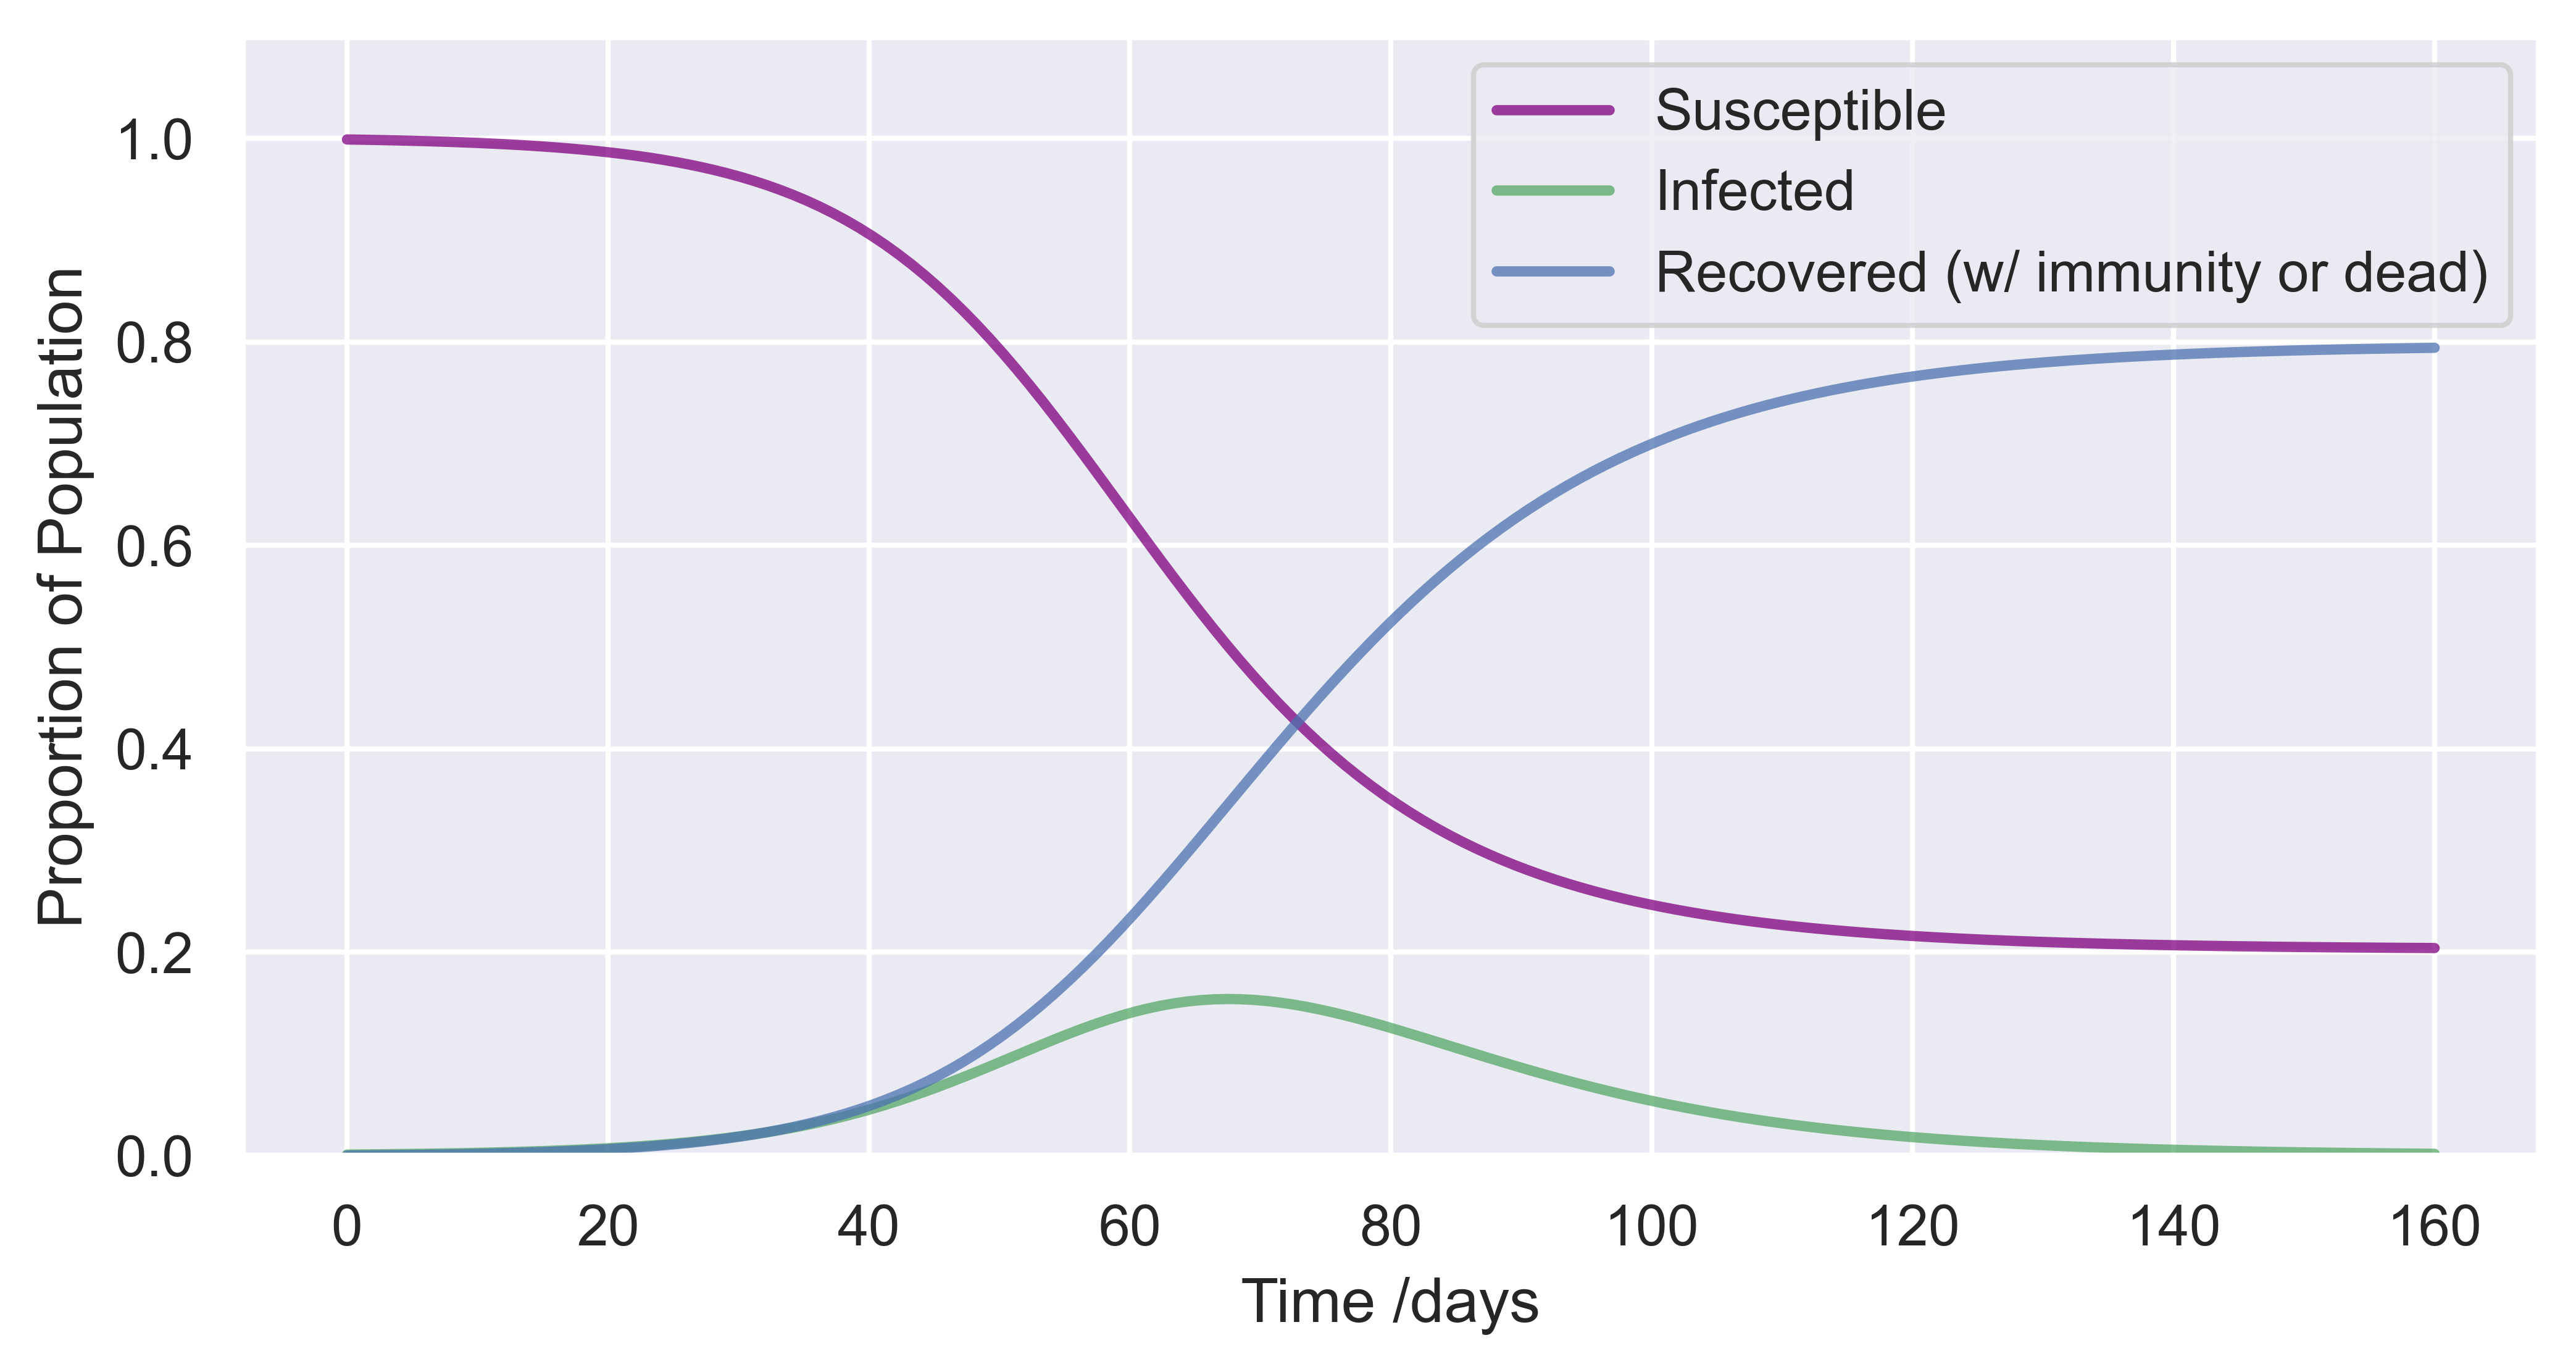

In [47]:
## From https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

import numpy as np
from scipy.integrate import odeint
sns.set()

# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w',figsize=(8,4))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/N, 'purple', alpha=.75, lw=2, label='Susceptible')
ax.plot(t, I/N, 'g',      alpha=.75, lw=2, label='Infected')
ax.plot(t, R/N, 'b',      alpha=.75, lw=2, label='Recovered (w/ immunity or dead)')
ax.set_xlabel('Time /days')
ax.set_ylabel('Proportion of Population')
ax.set_ylim(0,1.1)
# ax.yaxis.set_tick_params(length=0)
# ax.xaxis.set_tick_params(length=0)
# ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
# legend.get_frame().set_alpha(0.5)
# for spine in ('top', 'right', 'bottom', 'left'):
#     ax.spines[spine].set_visible(False)
plt.show()